In [2]:
import scipy.io
import numpy as np
import mne
import os
import gym
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [3]:
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler


class NDStandardScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [1]:
import pywt
import scipy.signal
from scipy import stats
def mean(x):
    return np.mean(x, axis=-1).reshape(-1, 1)

def stddev(x):
    return np.std(x, axis=-1).reshape(-1, 1)

def peaktopeak(x):
    return np.ptp(x, axis=-1).reshape(-1, 1)

def variance(x):
    return np.var(x, axis=-1).reshape(-1, 1)

def mini(x):
    return np.min(x, axis=-1).reshape(-1, 1)

def maxi(x):
    return np.max(x, axis=-1).reshape(-1, 1)

def argmini(x):
    return np.argmin(x, axis=-1).reshape(-1, 1)

def argmaxi(x):
    return np.argmax(x, axis=-1).reshape(-1, 1)

def rms(x):
    return np.sqrt(np.mean(x**2, axis=-1)).reshape(-1, 1)

def abs_diff_signal(x):
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1).reshape(-1, 1)

def skewness(x):
    return stats.skew(x, axis=-1).reshape(-1, 1)

def kurtosis(x):
    return stats.kurtosis(x, axis=-1).reshape(-1, 1)

def concat_features(x):
    features = np.concatenate(
        (
            peaktopeak(x),
            rms(x),
            abs_diff_signal(x),
            skewness(x),
            kurtosis(x),
            variance(x),
            mean(x),
            stddev(x)
        ),
        axis=1
    )
    return features

def apply_cwt(data, scales, wavelet_name='morl'):
    """
    Apply Continuous Wavelet Transform (CWT) to EEG data.

    :param data: EEG data in CSP space with shape (components, timepoints)
    :param scales: Scales for CWT
    :param wavelet_name: Name of the mother wavelet for CWT
    :return: CWT coefficients
    """
    cwt_coeffs = np.array([pywt.cwt(data[i, :], scales, wavelet_name)[0] for i in range(data.shape[0])])
    return cwt_coeffs

    
def featuresarray_load(data_array):
    features = []
    fs = 250
    for d in data_array:
        
        #theta = mne.filter.filter_data(d, sfreq=fs, l_freq=4, h_freq=7, verbose=False)
        alpha = mne.filter.filter_data(d, sfreq=fs, l_freq=8, h_freq=12,verbose=False)
        beta = mne.filter.filter_data(d, sfreq=fs, l_freq=12, h_freq=30,verbose=False)
        
        alph_ftrs = concat_features(alpha)
        beta_ftrs = concat_features(beta)
        #theta_ftrs = concat_features(beta)
        #nperseg = 256
        
        
        _,p=scipy.signal.welch(beta, fs=fs,average='median',nfft = 512)
        _,p2=scipy.signal.welch(alpha, fs=fs,average='median',nfft = 512)
        #_,p3 = scipy.signal.welch(theta, fs=fs,average='median',nfft = 256)

        res = np.mean([alph_ftrs,beta_ftrs],axis=0)
        #print('p',p.shape,res.shape)
        res = np.concatenate((res,p2,p),axis=1)
        #print(res.shape)
        features.append(res)
    return np.array(features)

In [5]:
def save_as_annotated_fif():
    import mne

    # Define task duration and break duration in seconds
    task_duration = 5
    break_duration = 3
    session_start_time = 30  # in seconds

    # Define mapping for task names
    task_labels = {
        "Left Hand Movement": "left_hand",
        "Right Hand Movement": "right_hand",
        "Blinking": "blinking",
        "Jaw Clenching": "jaw_clenching"
    }

    # Define the path to your BDF files and the annotations file
    bdf_files = [
        "session11.bdf", "session12.bdf", "session13.bdf", "session14.bdf", 
        "session15.bdf", "session16.bdf", "session17.bdf", "session18.bdf", 
        "session19.bdf", "session20.bdf", "session21.bdf"
    ]
    annotations_file = "collected_data/annotations.txt"

    # Read task order from the annotations file
    with open(annotations_file, "r") as f:
        data = f.read().split("_____________________________________________")

    # Process each session and add annotations
    for i, bdf_file in enumerate(bdf_files):
        # Load the BDF file
        raw = mne.io.read_raw_bdf("collected_data/"+bdf_file, preload=True)
        raw.drop_channels(['EEG 7', 'EEG 8', 'Accel X', 'Accel Y', 'Accel Z'])
        # Parse tasks for the current session
        session_tasks = data[i].strip().split("\n")[1:]  # Skip the session label

        # Initialize lists to store annotation details
        onsets = []
        durations = []
        descriptions = []

        # Set the current time to the session start time
        current_time = session_start_time
        for task_name in session_tasks:
            # Map task name to a short label and add annotation details
            descriptions.append(task_labels[task_name])
            onsets.append(current_time)
            durations.append(task_duration)

            # Update time for the next task (task duration + break)
            current_time += task_duration + break_duration

        # Create annotations and add them to the raw data
        annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)
        raw.set_annotations(annotations)

        # Save the annotated file in .fif format
        annotated_file = bdf_file.replace(".bdf", "_annotated.fif")
        raw.save("collected_data/"+annotated_file, overwrite=True)
        print(f"Annotations added and saved to {annotated_file}")


In [6]:
import mne
from mne.decoding import CSP
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
import numpy as np
import os

# Define paths and parameters
data_folder = "collected_data/"
fif_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith("_annotated.fif")]
tmin, tmax = 0., 5.  # Epoch duration in seconds after each event
task_duration = 5  # Task duration if needed

# Labels dictionary for annotation mapping
task_labels = {"left_hand": 0, "right_hand": 1}

# Initialize empty lists to store data and labels across all files
X_all = []
y_all = []

# Loop through each .fif file and extract epochs for left and right hand movements
for fif_file in fif_files:
    # Load the annotated .fif file
    raw = mne.io.read_raw_fif(fif_file, preload=True,verbose=False)
    
    
    
    # Extract events and map event IDs to left and right movements
    events, event_id = mne.events_from_annotations(raw,verbose=False)
    left_id = event_id.get("left_hand")
    right_id = event_id.get("right_hand")
    
    # Create epochs for left and right movements only
    epochs = mne.Epochs(raw, events, event_id=[left_id, right_id], tmin=tmin, tmax=tmax,
                        baseline=None, preload=True, verbose=False)
    
    # Extract data and labels
    X = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
    y = epochs.events[:, -1]  # Labels: left_id for left hand, right_id for right hand
    
    # Convert labels to binary: 0 for left hand, 1 for right hand
    y = np.where(y == left_id, 0, 1)
    
    # Append data and labels to the lists
    X_all.append(X)
    y_all.append(y)

# Concatenate all data and labels
X_all = np.concatenate(X_all, axis=0)  # Combine all epochs
y_all = np.concatenate(y_all, axis=0)  # Combine all labels

# Initialize CSP with 4 components and define the classifier (Support Vector Machine)
csp = CSP(n_components=6, norm_trace=False)
svc = SVC(kernel='sigmoid', C=100)

# Create a pipeline for CSP and SVM
clf = Pipeline([('CSP', csp), ('SVM', svc)],verbose=False)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.4, random_state=42, stratify=y_all)

# Fit the model on training data
clf.fit(X_train, y_train)

# Evaluate with cross-validation on the training set
scores = cross_val_score(clf, X_train, y_train, cv=10, verbose=False)
print("Training accuracy (cross-validation):", scores.mean())

# Test the model on the test set
test_accuracy = clf.score(X_test, y_test)
print("Test accuracy:", test_accuracy)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\3860819556.py:26: RuntimeWarning: This filename (collected_data/session10_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True,verbose=False)


Computing rank from data with rank=None


C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\3860819556.py:26: RuntimeWarning: This filename (collected_data/session11_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True,verbose=False)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\3860819556.py:26: RuntimeWarning: This filename (collected_data/session12_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True,verbose=False)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\3860819556.py:26: RuntimeWarning: This filename (collected_data/session13_annotated.fif) 

    Using tolerance 0.0004 (2.2e-16 eps * 6 dim * 3e+11  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 6 dim * 2.8e+11  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 6 dim * 2.8e+11  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Do

In [7]:
def plot_stuff():
    import mne

    # Load data
    raw = mne.io.read_raw_fif("collected_data/session1_annotated.fif", preload=True)

    # Plot with different scaling for EEG
    raw.plot(scalings=dict(eeg=100), title="Adjusted Scaling for EEG Signals")

    # Plot Power Spectral Density to check for high-frequency noise
    raw.plot_psd(fmax=50, average=True)

    # Define the mapping from old names to new names
    mapping = {
        'EEG 1': 'FCz',
        'EEG 2': 'C3',
        'EEG 3': 'C1',
        'EEG 4': 'CPz',
        'EEG 5': 'C2',
        'EEG 6': 'C4'
    }

    raw.rename_channels(mapping)
    # Load the standard 10-20 montage
    montage = mne.channels.make_standard_montage('standard_1020')

    # Apply the montage to your raw data
    raw.set_montage(montage)

    # Now you can fit and plot ICA components
    ica = mne.preprocessing.ICA(n_components=6, random_state=97, max_iter=800)
    ica.fit(raw)
    ica.plot_components()  # Visualize ICA components to identify potential artifacts
    # Plot the time series of all ICA components
    ica.plot_sources(raw)  # raw is your raw data object


In [9]:
import mne
from mne.decoding import CSP
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import numpy as np
import os
import random

# Define the directory and parameters
data_folder = "collected_data/"
fif_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith("_annotated.fif")]
tmin, tmax = 0., 2.  # Time window for epochs
num_iterations = 100
  # Number of trials with random ICA exclusions
num_components_to_remove = 4  # Number of components to remove each time

# Initialize storage for combined data and labels
X_all = []
y_all = []

# Aggregate epochs from all annotated .fif files
for fif_file in fif_files:
    print(f"Processing file: {fif_file}")
    raw = mne.io.read_raw_fif(fif_file, preload=True)
    events, event_id = mne.events_from_annotations(raw)

    # Define left and right hand movement events
    left_event = event_id.get("left_hand")
    right_event = event_id.get("right_hand")

    # Extract epochs for left and right hand movements
    epochs = mne.Epochs(raw, events, event_id=[left_event, right_event], tmin=tmin, tmax=tmax, baseline=None, preload=True)
    X = epochs.get_data()
    y = np.where(epochs.events[:, -1] == left_event, 0, 1)  # 0 for left, 1 for right

    # Append to the overall data
    X_all.append(X)
    y_all.append(y)

# Concatenate all data and labels across files
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)



# Set up CSP and classifier pipeline
csp = CSP(n_components=10
          , norm_trace=False)
svc = SVC(kernel='sigmoid', C=1)
clf = Pipeline([('CSP', csp), ('SVM', svc)])

# Initialize a list to store accuracy results
accuracy_results = []


# Loop over random samples of ICA components
for _ in range(num_iterations):
    # Randomly select components to exclude
    

    # Recompute epochs on cleaned data
    X_cleaned = X_all.copy()
    y_cleaned = y_all.copy()

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.1, random_state=42, stratify=y_cleaned)

    # Fit and evaluate classifier
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)

    

# Display all results
for result in accuracy_results:
    print(f"Excluded Components: {result['excluded_components']}, Test Accuracy: {result['accuracy']:.4f}")


Processing file: collected_data/session10_annotated.fif
Opening raw data file collected_data/session10_annotated.fif...
Isotrak not found
    Range : 0 ... 16499 =      0.000 ...    65.996 secs
Ready.
Reading 0 ... 16499  =      0.000 ...    65.996 secs...
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_hand', 'right_hand']
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 501 original time points ...
0 bad epochs dropped
Processing file: collected_data/session11_annotated.fif
Opening raw data file collected_data/session11_annotated.fif...
Isotrak not found
    Range : 0 ... 16999 =      0.000 ...    67.996 secs
Ready.
Reading 0 ... 16999  =      0.000 ...    67.996 secs...
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_hand', 'right_hand']
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Usi

C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session10_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session11_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session12_annotated.fif) does not conform to MNE naming 

0 projection items activated
Using data from preloaded Raw for 2 events and 501 original time points ...
0 bad epochs dropped
Processing file: collected_data/session15_annotated.fif
Opening raw data file collected_data/session15_annotated.fif...
Isotrak not found
    Range : 0 ... 16499 =      0.000 ...    65.996 secs
Ready.
Reading 0 ... 16499  =      0.000 ...    65.996 secs...
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_hand', 'right_hand']
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 501 original time points ...
0 bad epochs dropped
Processing file: collected_data/session16_annotated.fif
Opening raw data file collected_data/session16_annotated.fif...
Isotrak not found
    Range : 0 ... 16499 =      0.000 ...    65.996 secs
Ready.
Reading 0 ... 16499  =      0.000 ...    65.996 secs...
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_han

C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session15_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session16_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session17_annotated.fif) does not conform to MNE naming 

Ready.
Reading 0 ... 16249  =      0.000 ...    64.996 secs...
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_hand', 'right_hand']
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 501 original time points ...
0 bad epochs dropped
Processing file: collected_data/session1_annotated.fif
Opening raw data file collected_data/session1_annotated.fif...
Isotrak not found
    Range : 0 ... 16249 =      0.000 ...    64.996 secs
Ready.
Reading 0 ... 16249  =      0.000 ...    64.996 secs...
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_hand', 'right_hand']
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 501 original time points ...
0 bad epochs dropped
Processing file: collected_data/session20_annotated.fif
Opening raw data file collected_data/session20

C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session1_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session20_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session21_annotated.fif) does not conform to MNE naming c

Isotrak not found
    Range : 0 ... 16749 =      0.000 ...    66.996 secs
Ready.
Reading 0 ... 16749  =      0.000 ...    66.996 secs...
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_hand', 'right_hand']
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 501 original time points ...
0 bad epochs dropped
Processing file: collected_data/session5_annotated.fif
Opening raw data file collected_data/session5_annotated.fif...
Isotrak not found
    Range : 0 ... 16249 =      0.000 ...    64.996 secs
Ready.
Reading 0 ... 16249  =      0.000 ...    64.996 secs...
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_hand', 'right_hand']
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 501 original time points ...
0 bad epochs dropped
Processing file: collected_d

C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session5_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session6_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_18572\180710794.py:25: RuntimeWarning: This filename (collected_data/session7_annotated.fif) does not conform to MNE naming con

0 projection items activated
Using data from preloaded Raw for 2 events and 501 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 6 dim * 2.3e+11  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 6 dim * 2.3e+11  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 6 dim * 2.3e+11  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from

In [10]:
def combine_fifs():
    import mne
    import os

    # Directory where your BDF files are stored
    data_folder = 'collected_data'
    bdf_files = [os.path.join(data_folder, f'session{x}_annotated.fif') for x in range(11, 22)]  # Update as necessary
    bdf_files.append("formatted_data/S01.fif")
    # Initialize an empty Raw object for concatenation
    raw_combined = None

    # Loop through each BDF file and concatenate
    for bdf_file in bdf_files:
        # Load the BDF file
        raw = mne.io.read_raw_fif(bdf_file, preload=True)
        
        # Concatenate the data
        if raw_combined is None:
            raw_combined = raw
        else:
            raw_combined.append(raw)

    # Save the combined data into a new BDF file
    combined_bdf_path = os.path.join("formatted_data", 'S01.fif')
    raw_combined.save(combined_bdf_path, overwrite=True)
    print(f"Combined FIF file saved as {combined_bdf_path}")


Opening raw data file formatted_data/S01.fif...
Isotrak not found
    Range : 0 ... 348249 =      0.000 ...  1392.996 secs
Ready.


C:\Users\ncvn\AppData\Local\Temp\ipykernel_15824\3905805038.py:5: RuntimeWarning: This filename (formatted_data/S01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif("formatted_data/S01.fif", preload=True)


Reading 0 ... 348249  =      0.000 ...  1392.996 secs...
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_hand', 'right_hand']
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 1251 original time points ...
0 bad epochs dropped


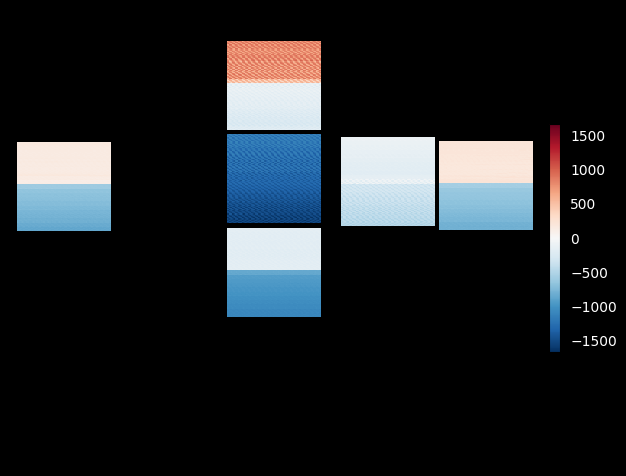

Epochs data shape: (84, 6, 1251)
Labels shape: (84,)


In [2]:
import mne
import numpy as np

# Load the combined .fif file
raw = mne.io.read_raw_fif("formatted_data/S01.fif", preload=True)

# Rename channels if needed (you can skip this if they are already correct)
mapping = {
    'EEG 1': 'FCz',
    'EEG 2': 'C3',
    'EEG 3': 'Cz',
    'EEG 4': 'CPz',
    'EEG 5': 'C2',
    'EEG 6': 'C4'
}
raw.rename_channels(mapping)

# Set montage (for visualization and correct EEG locations)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# Extract events and event IDs
events, event_id = mne.events_from_annotations(raw)

# Define each task based on event markers in the combined file
# Here, 'left_hand', 'right_hand', 'blinking', and 'jaw_clenching' should be keys in your annotations
left_event = event_id.get("left_hand")
right_event = event_id.get("right_hand")
blink_event = event_id.get("blinking")
jaw_event = event_id.get("jaw_clenching")

# Define epoch parameters to capture the full 5 seconds of each task
tmin = 0  # Start at the event marker
tmax = 5  # End 5 seconds after the event marker to capture the full task duration

# Extract epochs for all events of interest
epochs = mne.Epochs(
    raw, events, event_id=[left_event, right_event, blink_event, jaw_event],
    tmin=tmin, tmax=tmax, baseline=None, preload=True
)

# Visualize the epochs to verify
epochs.plot_topo_image()

# Get the data and labels
X = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
y = np.where(epochs.events[:, -1] == left_event, 0,  # 0 for left hand
             np.where(epochs.events[:, -1] == right_event, 1,  # 1 for right hand
                      np.where(epochs.events[:, -1] == blink_event, 2,  # 2 for blinking
                               3)))  # 3 for jaw clenching

# X and y now contain the data and labels for each event, ready for further processing
print("Epochs data shape:", X.shape)
print("Labels shape:", y.shape)


In [3]:
X.shape,y

((84, 6, 1251),
 array([2, 3, 1, 0, 1, 2, 3, 0, 1, 3, 2, 0, 2, 3, 0, 1, 2, 3, 1, 0, 1, 3,
        2, 0, 2, 1, 3, 0, 1, 2, 0, 3, 3, 1, 2, 0, 1, 2, 0, 3, 0, 2, 3, 1,
        2, 3, 1, 0, 1, 2, 3, 0, 1, 3, 2, 0, 2, 3, 0, 1, 2, 3, 1, 0, 1, 3,
        2, 0, 2, 1, 3, 0, 1, 2, 0, 3, 3, 1, 2, 0, 1, 2, 0, 3]))

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mne.decoding import CSP
import mne
from mne.decoding import CSP
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline

event_ids = [1,2,3,4]  
event_id_to_label = {}
for i in range(len(event_ids)):
    event_id_to_label[i] = event_ids[i]
print(event_id_to_label)
path = 'formatted_data/S01.fif'
raw = mne.io.read_raw_fif(path, preload=True)
ica = mne.preprocessing.ICA(n_components=len(raw.info['ch_names']), random_state=42, max_iter=1000)
ica.fit(raw)
ica.apply(raw)
csp_filters = {} 
events = mne.events_from_annotations(raw)

{0: 1, 1: 2, 2: 3, 3: 4}
Opening raw data file formatted_data/S01.fif...
Isotrak not found
    Range : 0 ... 348249 =      0.000 ...  1392.996 secs
Ready.
Reading 0 ... 348249  =      0.000 ...  1392.996 secs...
Fitting ICA to data using 6 channels (please be patient, this may take a while)


C:\Users\ncvn\AppData\Local\Temp\ipykernel_15824\2630978084.py:23: RuntimeWarning: This filename (formatted_data/S01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)
C:\Users\ncvn\AppData\Local\Temp\ipykernel_15824\2630978084.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 6 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 0 ICA components
    Projecting back using 6 PCA components
Used Annotations descriptions: ['blinking', 'jaw_clenching', 'left_hand', 'right_hand']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft


all_epochs = mne.Epochs(raw, events[0], event_id=[1,2,3,4],  # No specific event_id filtering
                        tmin=-0.5, tmax=5.5, baseline=(-0.5,1), preload=True)
all_epochs.pick_types(meg=False, eeg=True)

X_all = all_epochs.get_data()
save_copy = X_all.copy()

event_ids_all = all_epochs.events[:, -1]
print(X_all.shape,event_ids_all.shape)

ncomp = 4
csp_transformed_data = {}
for event_id in [1,2,3,4]:
    y = (event_ids_all == event_id).astype(int)
    if np.unique(y).size < 2:
        print(f"Skipping event_id {event_id}.")
        continue

    csp = CSP(n_components=ncomp, norm_trace=False, transform_into='csp_space')
    csp.fit(X_all, y)
    csp_transformed_data[event_id] = csp.transform(X_all)

print('CSP FILTERS DICT:',csp_transformed_data)
# Combine CSP features for each trial based on its label
n_trials = len(X_all)  # Number of trials
n_components = ncomp       # Number of CSP components (assuming 3 for this example)
n_time_points = csp_transformed_data[1].shape[2]   # Number of time points in the transformed CSP data

# Initialize the combined_features array to hold CSP features for all trials
combined_features = np.zeros((n_trials, n_components, n_time_points))

# Loop through each trial and assign the CSP-transformed data
for i, label in enumerate(event_ids_all):
    # Fetch the CSP features for the current trial and class label
    # Adjust the indexing based on how your labels and csp_transformed_data are structured
    csp_features_for_label = csp_transformed_data.get(label, None)

    # Check if the label exists in the dictionary and if the index is within bounds
    if csp_features_for_label is not None and i < len(csp_features_for_label):
        combined_features[i, :, :] = csp_features_for_label[i]

print(combined_features.shape)

print(combined_features.shape)
y = np.zeros((X_all.shape[0], len(event_ids)))  

for i, event_id in enumerate([1,2,3,4]):
    binary_labels = (event_ids_all == event_id).astype(int)
    y[:, i] = binary_labels  
print(y)

y_flattened = np.argmax(y, axis=1)
print(y_flattened)
print(y_flattened.tolist().count(0),y_flattened.tolist().count(1),y_flattened.tolist().count(2),y_flattened.tolist().count(3))
# clf = Pipeline([('scaler',StandardScaler()),('SVC', SVC())])
print('features shape: ',combined_features.shape,y_flattened.shape)
# scores = cross_val_score(clf, combined_features, y_flattened, cv=10, scoring='accuracy')
# print("Multiclass classification accuracy: %f" % scores.mean())

ftrs = featuresarray_load(combined_features)

print('features shape: ',ftrs.shape,y_flattened.shape)
X_train, X_test, y_train, y_test = train_test_split(ftrs, y_flattened, train_size=0.9, random_state=42, stratify=y_flattened)


from keras.layers import PReLU, Conv1D, Dropout, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, Layer, AveragePooling1D, LSTM, Reshape, BatchNormalization
from keras.regularizers import l1_l2

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
GLOBAL_SHAPE_LENGTH = ftrs.shape[2]
print(X_train.shape,X_test.shape)
model = Sequential([
        Reshape((GLOBAL_SHAPE_LENGTH,ncomp)),
        BatchNormalization(),

        Conv1D(32, kernel_size=3),
        BatchNormalization(),
        PReLU(),
        

        MaxPooling1D(pool_size=2),
        SpatialDropout1D(0.1),

        Conv1D(64, kernel_size=3),
        BatchNormalization(),
        PReLU(),
        AveragePooling1D(pool_size=2),
        SpatialDropout1D(0.1),

        LSTM(64, activation='tanh', recurrent_regularizer=l1_l2(l1=0.01, l2=0.01),return_sequences=True),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        BatchNormalization(),
        Dense(units=64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(units=32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(units=4, activation='softmax')
    ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32)


Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 1501 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
(84, 6, 1501) (84,)
Computing rank from data with rank=None
    Using tolerance 4.4e-05 (2.2e-16 eps * 6 dim * 3.3e+10  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-05 (2.2e-16 eps * 6 dim * 3.3e+10  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIR

In [ ]:
# np.save("combinedftrs.npy",X_all, allow_pickle=False)
# np.save("labels.npy", y_flattened, allow_pickle=False)

In [20]:
X_test.shape

(9, 4, 522)

In [ ]:
# import tensorflow as tf
# model = tf.keras.models.load_model('1dcnnlstm_model_88p_acc.keras')
print(model.evaluate(X_test,y_test)[1]*100.00)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.8889 - loss: 0.7485
88.88888955116272


In [ ]:
# Install Stable Baselines3
# !pip install stable-baselines3[extra]

import gym
import numpy as np
import random
import socket
import threading
import time
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

# Define your custom environment
class Plasticity(gym.Env):
    def __init__(self, images_per_episode=1, dataset=(X_train, y_train), random=True):
        super(Plasticity, self).__init__()
        self.action_space = gym.spaces.Discrete(4)  # 4 actions
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf,
                                                shape=(ncomp, GLOBAL_SHAPE_LENGTH),
                                                dtype=np.float32)
        self.images_per_episode = images_per_episode
        self.step_count = 0
        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):
        done = False
        reward = self.calculate_reward(action)
        obs = self._next_obs()
        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True
        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0
        return self._next_obs()

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]
        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])
            self.dataset_idx = (self.dataset_idx) % (len(X_train))
            # if self.dataset_idx >= len(self.x):
            #     raise StopIteration()
        return obs

    def calculate_reward(self, action):
        if action == self.expected_action:
            return 1.0
        else:
            return -1.0  # Negative reward for incorrect actions

# Instantiate the environment
env = Plasticity(images_per_episode=1, dataset=(X_train, y_train), random=True)

# Define callbacks
checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path='./models/',
    name_prefix='dqn_plasticity'
)

eval_env = Plasticity(images_per_episode=1, dataset=(X_test, y_test), random=False)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/',
    log_path='./logs/',
    eval_freq=1000,
    deterministic=True,
    render=False
)

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:
            print(f"Step: {self.n_calls}")
        return True

custom_callback = CustomCallback()

# Initialize the DQN agent
model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=1e-3,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    gamma=0.99,
    train_freq=4,
    target_update_interval=1000,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    tensorboard_log="./dqn_plasticity_tensorboard/"
)

# Train the agent
# model.learn(
#     total_timesteps=10000,
#     callback=[checkpoint_callback, eval_callback, custom_callback]
# )

# Save the trained model
# model.save("dqn_plasticity_final")

# Load the model (if needed)
model = DQN.load("dqn_plasticity_final", env=env)

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")



c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Logging to ./dqn_plasticity_tensorboard/DQN_4
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 309      |
|    time_elapsed     | 0        |
|    total_timesteps  | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 472      |
|    time_elapsed     | 0        |
|    total_timesteps  | 8        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | -0.833   |
|    exploration_rate | 0.988    |
| time/  

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | -0.48    |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1020     |
|    fps              | 688      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1020     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.406    |
|    n_updates        | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | -0.52    |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1024     |
|    fps              | 679      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1024     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.458    |
|    n_updates      

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [1]:
model = DQN.load("dqn_plasticity_final", env=env)

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

NameError: name 'DQN' is not defined

In [ ]:

# Define mapping from actions to car commands
def map_action_to_command(action):
    action_mapping = {
        0: 'LEFT',
        1: 'RIGHT',
        2: 'FORWARD',
        3: 'BACKWARD'
    }
    return action_mapping.get(action, 'STOP')  # Default to 'STOP' if action not found

# Real-time command transmission setup
# Replace with your actual EEG data acquisition and preprocessing logic
def acquire_eeg_data():
    pass

def preprocess_eeg(raw_data):
    
    return featuresarray_load(raw_data)  

# Set up socket connection to Arduino
arduino_ip = '192.168.1.X'  # Replace with your Arduino's IP
arduino_port = 12345         # Replace with your Arduino's listening port
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
try:
    sock.connect((arduino_ip, arduino_port))
    print("Connected to Arduino")
except Exception as e:
    print(f"Failed to connect to Arduino: {e}")

def real_time_control():
    while True:
        # Acquire EEG data
        raw_data = acquire_eeg_data()  # Implement this function

        # Preprocess EEG data
        features = preprocess_eeg(raw_data)

        # Ensure features are in the correct shape (1, GLOBAL_SHAPE_LENGTH, ncomp)
        features = np.expand_dims(features, axis=0).astype(np.float32)

        # Predict action using the RL agent
        action, _states = model.predict(features, deterministic=True)

        # Map action to command
        command = map_action_to_command(action)

        # Send command to Arduino
        try:
            sock.sendall(command.encode())
            print(f"Sent command: {command}")
        except Exception as e:
            print(f"Error sending command: {e}")

        # Control the loop frequency (e.g., 10 Hz)
        time.sleep(0.1)

# Run the control loop in a separate thread
control_thread = threading.Thread(target=real_time_control, daemon=True)
control_thread.start()

# Keep the main thread alive
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Stopping real-time control.")
    sock.close()

Exception in thread Thread-45 (real_time_control):
Traceback (most recent call last):
  File "C:\Users\ncvn\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\ncvn\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\ncvn\AppData\Local\Temp\ipykernel_15144\1769462296.py", line 45, in real_time_control
  File "c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\stable_baselines3\dqn\dqn.py", line 255, in predict
    action, state = self.policy.predict(observation, state, episode_start, deterministic)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\stable_baselines3\common\polici

Failed to connect to Arduino: [Errno 11001] getaddrinfo failed
Stopping real-time control.
